<a href="https://colab.research.google.com/github/Juxtpawan/AIML/blob/main/pytorch5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print(torch.__version__)

2.9.0+cpu


In [ ]:
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm

In [ ]:
# Load Data
train_dataset = datasets.MNIST(root="data/MNIST", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="data/MNIST", train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 142MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 19.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 58.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.34MB/s]


In [ ]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

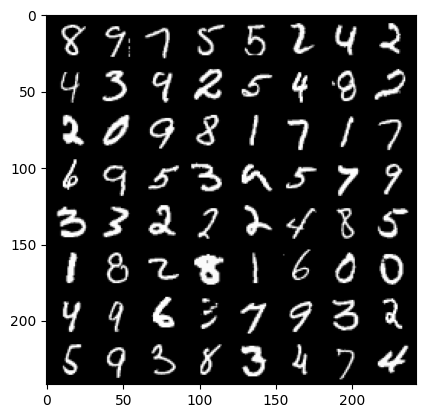

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import numpy as np
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))


In [ ]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Defines layers of the neural network (create two fully connected layers)
        Parameters:
            input_size: size of the input, for us its 784 (28x28)
            num_classes: no. of classes needed to predict, for us its 10 (0-9)
        """
        super(SimpleNeuralNet, self).__init__()
        self.fully_connected_1 = nn.Linear(input_size, 50)
        self.fully_connected_2 = nn.Linear(50, num_classes)
    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1 (fully connected 1), fc2 (fully connected 1) that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters) its recommended to use nn.functional (F)

        Parameters:
            x: mnist images
        Returns:
            out: output of the network
        """
        x = F.relu(self.fully_connected_1(x))
        x = self.fully_connected_2(x)
        return x


In [ ]:
# Hyperparameters
input_size = 784
num_classes = 10
learning_rate = 0.001
# Initialize network
model = SimpleNeuralNet(input_size=input_size, num_classes=num_classes)  #.to(device)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 2
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # If possible push the data to GPU
        data = data.to(device=device)
        targets = targets.to(device=device)
        # Get the right shape
        data = data.reshape(data.shape[0], -1)
        # Forward Prop
        scores = model(data)
        loss = criterion(scores, targets)
        # Backward Prop
        optimizer.zero_grad()
        loss.backward()
        # Gradient descent or adam step
        optimizer.step()


100%|██████████| 938/938 [00:09<00:00, 102.34it/s]


In [ ]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model
    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on
    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """
    num_correct = 0
    num_samples = 0
    model.eval()
    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:
            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)
            # Get to correct shape
            x = x.reshape(x.shape[0], -1)
            # Forward pass
            scores = model(x)
            _, predictions = scores.max(1)
            # Check how many we got correct
            num_correct += (predictions == y).sum()
            # Keep track of number of samples
            num_samples += predictions.size(0)
    model.train()

    return num_correct / num_samples


In [ ]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 95.31
Accuracy on test set: 95.23


In [ ]:
# state_dict(): called on the model object to retrieve its state dictionary (current state i.e learned weights of the model)
print(model.state_dict())

OrderedDict({'fully_connected_1.weight': tensor([[ 0.0233,  0.0066,  0.0030,  ...,  0.0217,  0.0203, -0.0322],
        [-0.0330, -0.0254, -0.0354,  ..., -0.0169, -0.0263,  0.0352],
        [-0.0040,  0.0174,  0.0341,  ..., -0.0112, -0.0163, -0.0217],
        ...,
        [ 0.0313, -0.0100, -0.0029,  ..., -0.0097, -0.0182, -0.0057],
        [ 0.0219,  0.0047, -0.0224,  ..., -0.0217, -0.0171,  0.0308],
        [ 0.0212, -0.0043, -0.0006,  ..., -0.0312,  0.0127,  0.0265]]), 'fully_connected_1.bias': tensor([-0.1468, -0.0049, -0.0457, -0.0389,  0.1682,  0.1043,  0.0569,  0.2198,
        -0.0597,  0.0694,  0.0480,  0.0141,  0.1763, -0.0145,  0.0290, -0.0792,
         0.1028,  0.1686, -0.0800, -0.0571, -0.0157,  0.0230,  0.2120, -0.0776,
         0.0782,  0.0840,  0.0175, -0.0773,  0.0259,  0.0291,  0.1362,  0.0720,
         0.0414,  0.1018, -0.1133, -0.0115,  0.2022, -0.0688,  0.1759, -0.0035,
         0.0056, -0.0377,  0.0746, -0.1164, -0.0284,  0.0110, -0.0287,  0.0687,
         0.0164,  

In [ ]:
from pathlib import Path
# Saving the Model
output_dir = Path('Final/model_binaries')
output_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), output_dir / 'model_2.pt')

In [ ]:
#Loading the Model from state dict
state_dict = torch.load( 'Final/model_binaries/model_2.pt')
# Testing the loaded state_dict with new instance of the "NN" class
new_model = SimpleNeuralNet(input_size=input_size, num_classes=num_classes)
new_model.load_state_dict(state_dict)

<All keys matched successfully>